# Simple Identify Sentiments problem

<img src="imgs/logo.jpg" width=80% style="float: center;"></img>
Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations. Brands can use this data to measure the success of their products in an objective manner. 

__*In this challenge, you are provided with tweet data to predict sentiment on electronic products of netizens.*__

Details of the problem statement and dataset could be refer to this page:  [here](https://datahack.analyticsvidhya.com/contest/linguipedia-codefest-natural-language-processing-1/)

__*Reference*__
- [deep.ai cources](https://www.coursera.org/specializations/deep-learning?)
- [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

In [1]:
# Libraries used in Loading and catching a glimpse of dataset
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import re
import json
import pandas as pd 
pd.set_option("display.max_colwidth", 150)
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
# Libraries used in part of processing tweets
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tf.reset_default_graph
print(tf.__version__)

1.14.0


In [3]:
# Libraries used in modeling
from tensorflow.keras.layers import Bidirectional, GRU, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

### Global arguments

- `VOCAB_SIZE`: We take 10,000 word in our vocaburary, and add one more for the word 'unknown'. If we use LSTM/GRU, it will ignore the padding part. And for the vector of UNKNOWN, we can not just set 0 like the padding because UNKNOWN also contains some information.

https://github.com/keras-team/keras/issues/9637

In [4]:
DATA_PATH = 'dataset/train_2kmZucJ.csv'
# this is the pre-trained word-embedding path, remember to replace it with your own path
WV_PATH = 'pre_train_wordVec/glove.twitter/glove.twitter.27B.200d.txt'
POS = 0
NEG = 1
VOCAB_SIZE = 10001
MAXLEN = 80
EMBED_DIM = 200
REG_L2 = tf.keras.regularizers.l2(0.001)

### Some figures

In [5]:
# display the length of tweets
def plt_len_tweets(tweets):
    length_train = tweets.str.len()
    plt.xlabel('length')
    plt.ylabel('frequency')
    
    plt.hist(length_train, bins=25, label="train_tweets")
    plt.legend()
    plt.show()
    
# display the hashtags of tweets for analysing their impacts
def hashtag_collect(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

def plt_hashtags(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 20 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 20) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    ax.set(ylabel = 'Count')
    plt.show()
    

#display word clould of the dataset
def plt_wordclould(val_label,text):
    all_words = ' '.join([text for text in train[text][train['label'] == val_label]])
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

    
#plot the graphs for visualizing the training variation
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# 1. Loading and catching a glimpse of dataset

Most profane and vulgar terms in the tweets have been replaced with “$&@*#”. 
However, please note that the dataset still might contain text that may be considered profane, vulgar, or offensive.

In [6]:
train  = pd.read_csv(DATA_PATH)
train.shape

(7920, 3)

In [7]:
# list top 10 positive tweets in dataset
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
6,7,0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/
7,8,0,New Type C charger cable #UK http://www.ebay.co.uk/itm/-/112598674021 … #bay #Amazon #etsy New Year #Rob Cross #Toby Young #EVEMUN #McMafia #Taylo...
8,9,0,Bout to go shopping again listening to music #iphone #justme #music #likeforlike #followforfollow… http://instagr.am/p/Vj6bg5tLql/
9,10,0,Photo: #fun #selfie #pool #water #sony #camera #picoftheday #sun #instagood #boy #cute #outdoor... http://tmblr.co/ZAjC0n1ms_Gp8
13,14,0,"I just made another crazy purchase lol my theory is 'Work hard, Play Hard' Lol #iPad #Apple #Shopping http://instagr.am/p/NUyFHvyE7I/"
15,16,0,From #DeepEllum towards #downtown #Dallas. #BigD #Saturday #RX100M3 #Sony #summer #urban http://instagram.com/p/pzJoOaQqZ4/


In [8]:
# list top 10 negetive tweets in dataset
train[train['label'] == 1].head(10)

,id,label,tweet
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,6,1,iPhone software update fucked up my phone big time Stupid iPhones
10,11,1,hey #apple when you make a new ipod dont make it a new color or .2inches thinner make it not crash every five fuckin minite.
11,12,1,Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade
12,13,1,Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo
14,15,1,@shaqlockholmes @sam_louise1991 the battery is so painful! I charge it overnight and by lunchtime battery is dead! #HateOrange.
18,19,1,The reason I don't have one. #iphone #suck #apple #truth #truthbetold #agree #fact #realitycheck #blackberrypic.twitter.com/zpggd7caZN
19,20,1,How is the apple store gunna be out of 5C screens ?!? It's Monday and ur the FUCKING APPLE STORE !!! #fuckingpissed
22,23,1,I've had this new ipod for four days? And this of button on the back broke... I accidentally hit it once
23,24,1,when your iPhone screen goes completely black and you keep getting texts all day but you can't FUCKING CHECK THEM #Apple #6thiPhone


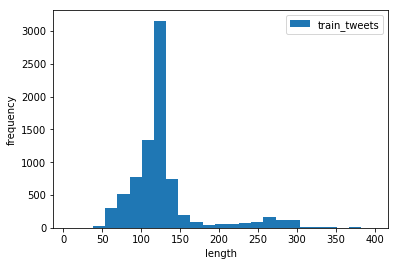

In [9]:
plt_len_tweets(train['tweet'])

__*Understanding the impact of Hashtags on tweets sentiment*__

In [10]:
# extracting hashtags from negative tweets
ht_positive = hashtag_collect(train['tweet'][train['label'] == 0])

# extracting hashtags from negative tweets
ht_negative = hashtag_collect(train['tweet'][train['label'] == 1])

# unnesting list
ht_positive = sum(ht_positive,[])
ht_negative = sum(ht_negative,[])

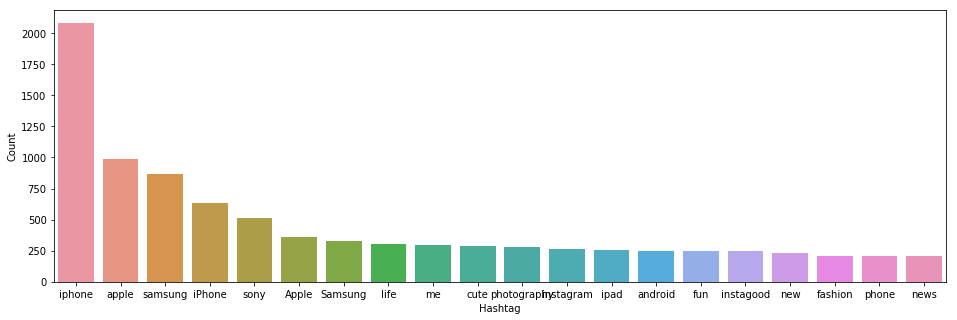

In [11]:
#display the positive #hashtags
plt_hashtags(ht_positive)

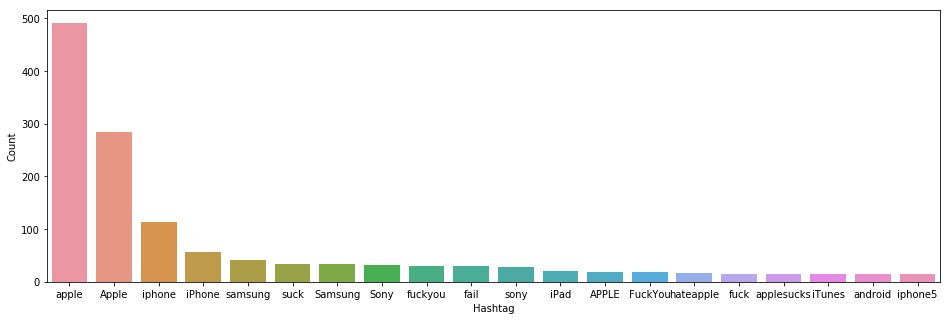

In [12]:
#display the positive #hashtags
plt_hashtags(ht_negative)

__*most of the hashtags has no help to identity the sentiments*__

# 2. Data processing
## 2.1 Data cleaning
remove the redundant/helpless infors

In [13]:
def cleaning(tweets,isSample_predict):
    if isSample_predict:
        tweets = re.sub(r'http\S+', '', tweets)
        tweets = re.sub(r'@[A-Za-z0-9]+','',tweets)
        tweets = tweets.replace("[0-9]", ' ')
        tweets = re.sub(r'#[A-Za-z0-9]+','',tweets)
        tweets = re.sub(r"[-()\"#/@$&;:<>{}`+=~|.!?,]", '', tweets)
    else:
        # remove URL
        tweets = tweets.apply(lambda x: re.sub(r'http\S+', '', x))
        # remove @user
        tweets = tweets.apply(lambda x: re.sub(r'@[A-Za-z0-9]+','',x))
        # remove numbers
        tweets = tweets.str.replace("[0-9]", " ")
        # remove whitespaces
        tweets = tweets.apply(lambda x:' '.join(x.split()))
        # remove hashtags
        tweets = tweets.apply(lambda x: re.sub(r'#[A-Za-z0-9]+','',x))
        # remove punctuation
        tweets = tweets.apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))

    return tweets 

In [14]:
train['tweet_clean'] = cleaning(train['tweet'],False)
train.head(5)

,id,label,tweet,tweet_clean
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,Test
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,Finally a transparant silicon case Thanks to my uncle …
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,We love this Would you go
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,Im wired I know Im George I was made that way
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,What amazing service Apple wont even talk to me about a question I have unless I pay them for their stupid support


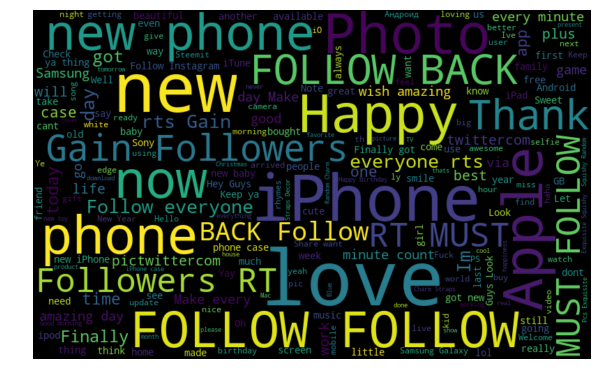

In [15]:
#display positive word
plt_wordclould(POS,'tweet_clean')

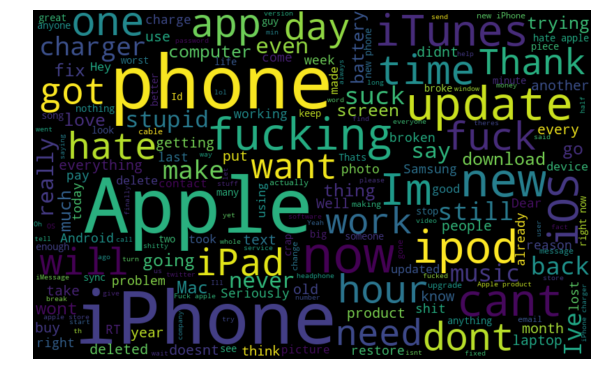

In [16]:
#display positive word
plt_wordclould(NEG,'tweet_clean')

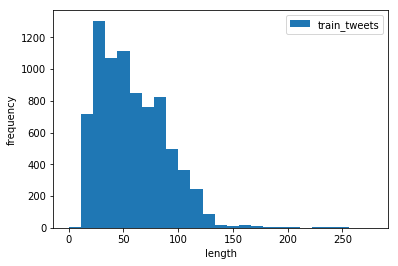

In [17]:
#display the length of tweets after cleaning
plt_len_tweets(train['tweet_clean'])

As the figure shown, the most number of tweets length less than (about) 80

## 2.2 dataset for Evalution the model
because I don't have enough dataset to do the evalution, so I decide to shuffle the train dataset and take some of them to evaluate my model 

In [18]:
from sklearn.utils import shuffle

shuf_data = shuffle(train)
shuf_data.head(5)

,id,label,tweet,tweet_clean
5243,5244,1,"I'd sell my iMac but it's NEARLY A YEAR OLD, so obviously it's obsolete & worthless. #apple",Id sell my iMac but its NEARLY A YEAR OLD so obviously its obsolete worthless
1904,1905,0,Mama got a new phone... be prepared for portrait mode overload #iphonex #portraitmode #dog #dogs #dogsofinsta #dogsofaustin #dogsoﬁnstagram #atx #...,Mama got a new phone be prepared for portrait mode overload ﬁnstagram twittercomNFib Tue
7626,7627,0,Presenting you a case made of real rose! Hot sale for our first customers! Check out at the link in bio! #Apple #Samsung #iPhone #Luxury #Style #C...,Presenting you a case made of real rose Hot sale for our first customers Check out at the link in bio twittercomcdrR rnv g
5844,5845,0,Yeah! At home today. Welcome iPhoneX #gift #iPhoneX #theme #cydia pic.twitter.com/BlEhEbBRRn,Yeah At home today Welcome iPhoneX pictwittercomBlEhEbBRRn
1349,1350,1,"Either send a note on a pigeon or call my house phone, once again my iPhone has failed me. apple",Either send a note on a pigeon or call my house phone once again my iPhone has failed me apple


we could compare first 5 eval_datas with the original train data shown as above

then take about 3,000 lines used for evalution

In [19]:
x_eval = shuf_data['tweet_clean'][:3000]
y_eval = shuf_data['label'][:3000]
x_eval.shape,y_eval.shape

((3000,), (3000,))

## 2.3 Tokenizer

In [20]:
# Create padding sequence with a fix length
tokenizer = Tokenizer(num_words= VOCAB_SIZE,oov_token='UNK')
def token_pad(sequences,isPad):
    tokenizer.fit_on_texts(sequences)
    sequences = tokenizer.texts_to_sequences(sequences)
    
    if isPad:
        sequences = pad_sequences(sequences, maxlen= MAXLEN, padding='post')
    return sequences

In [21]:
seq_pad = token_pad(train['tweet_clean'],True)
# Tokenization and padding of the evaluation data
x_eval = token_pad(x_eval,True)

In [22]:
#listing 5 tweets after tokenization
for i in range(5):
    print(seq_pad[i])

[1047    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  68    7 3681 2447   88   93    5    2 1564    6    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[ 60  27  21  82  10 107   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

In [23]:
tokenizer.index_word[1047],tokenizer.word_index['companies']

('story', 1228)

In [24]:
tokenizer.word_index['UNK'],tokenizer.index_word[1]

(1, 'UNK')

# 3. Modeling

By defaut I use (`adagrad`), and (`binary_crossentropy`)
- The problem is a logistic regression one rathen than a linear one.

In [25]:
def train_model(model,batch_sz):
    # Configures the model for training.
    model.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])
    # Train...
    history = model.fit(seq_pad,
                   train['label'],
                   batch_sz,
                   10,
                   2,
                   validation_split=0.2)
    
    return history

## 3.1 BiGRU

GRUs are improved version of standard recurrent neural network.

Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction. The GRU will use two gates to control whether to update the memory cell and control the output value from the GRU unit.

![Picture of an GRU unite](imgs/gruUnite.jpg "GRU Unit")

![Picture of GRU Equation](imgs/gruEquation.png.jpg "GRU Equation")

There are many articles to explain what is the GRU, if you're not very clear about that, you could have a look at the post in my reference or at others.

A Bidirectional RNN(GRU) connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past (backwards) and future (forward) states simultaneously.

![Picture of Bidirectional GRU](imgs/BiRNN.JPG "GRU Equation")

Note: 
- because we don't want to caculate the padding vector(0 value), so we make (`mask_zero=True`) when we generating the embedding
- It outputs one value (`y`), if y < 0.5, it's treated like a negative output, so the output layer activator use (`sigmoid`)

The 1st model consists of an embedding layer, 2 BiGRU layers, 1 fully connected layes, and finally go throught a sigmoid layer

![Picture of 1st model](imgs/model_biGRU.jpg "architecture model1")


In [26]:
model_biGRU = Sequential(name = "Bidirectional GRU")
model_biGRU.add(Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True,input_length=MAXLEN,activity_regularizer=REG_L2,name="embedding"))
model_biGRU.add(Bidirectional(GRU(200,return_sequences = True,activity_regularizer=REG_L2),name = "biGUR_1"))
model_biGRU.add(Dropout(rate = 0.2,name = "dropout"))
model_biGRU.add(Bidirectional(GRU(100),name="biGUR_2"))
model_biGRU.add(Dense(100, activation='relu',name="Dense_biGRU"))
model_biGRU.add(Dense(1, activation='sigmoid',name="output"))
model_biGRU.summary()

W0627 18:23:08.137200 16412 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0627 18:23:08.168146 16412 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0627 18:23:08.173108 16412 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotU

Model: "Bidirectional GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 200)           2000200   
_________________________________________________________________
biGUR_1 (Bidirectional)      (None, 80, 400)           481200    
_________________________________________________________________
dropout (Dropout)            (None, 80, 400)           0         
_________________________________________________________________
biGUR_2 (Bidirectional)      (None, 200)               300600    
_________________________________________________________________
Dense_biGRU (Dense)          (None, 100)               20100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 2,802,201
Trainable params: 2,802,201
Non-trainable params: 0
_______________________________________

In [27]:
history = train_model(model_biGRU,512)

Train on 6336 samples, validate on 1584 samples


W0627 18:23:10.929671 16412 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/10
6336/6336 - 60s - loss: 0.6178 - acc: 0.7284 - val_loss: 0.5067 - val_acc: 0.7519
Epoch 2/10
6336/6336 - 63s - loss: 0.4032 - acc: 0.8240 - val_loss: 0.3598 - val_acc: 0.8504
Epoch 3/10
6336/6336 - 68s - loss: 0.2682 - acc: 0.9039 - val_loss: 0.3523 - val_acc: 0.8510
Epoch 4/10
6336/6336 - 74s - loss: 0.2141 - acc: 0.9282 - val_loss: 0.3388 - val_acc: 0.8712
Epoch 5/10
6336/6336 - 80s - loss: 0.1807 - acc: 0.9410 - val_loss: 0.3529 - val_acc: 0.8725
Epoch 6/10
6336/6336 - 85s - loss: 0.1537 - acc: 0.9527 - val_loss: 0.3708 - val_acc: 0.8605
Epoch 7/10
6336/6336 - 89s - loss: 0.1329 - acc: 0.9605 - val_loss: 0.4050 - val_acc: 0.8624
Epoch 8/10
6336/6336 - 92s - loss: 0.1171 - acc: 0.9675 - val_loss: 0.4165 - val_acc: 0.8573
Epoch 9/10
6336/6336 - 96s - loss: 0.1017 - acc: 0.9733 - val_loss: 0.4547 - val_acc: 0.8548
Epoch 10/10
6336/6336 - 100s - loss: 0.0895 - acc: 0.9784 - val_loss: 0.4926 - val_acc: 0.8504


### Create a graph of accuracy and loss over time

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

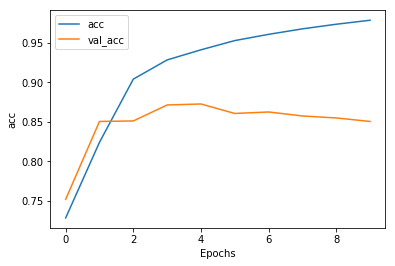

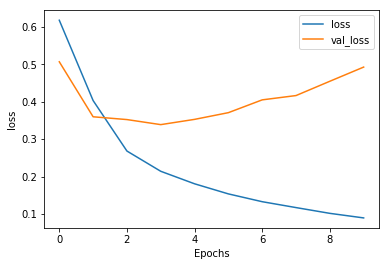

(None, None)

In [29]:
plot_graphs(history, 'acc'),plot_graphs(history, 'loss')

The model has an overfitting problem :(. After a bit epoches, loss of validation increases.

In [30]:
# Evaluate the model on the test data using `evaluate`
test_loss, test_acc = model_biGRU.evaluate(x_eval,y_eval,128)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

3000/3000 [==============================] - 11s 4ms/sample - loss: 1.3963 - acc: 0.7207
Test Loss: 1.3963386061986287
Test Accuracy: 0.7206666469573975


## 3.2 BiGRU + glove pre-train embedding


It is common to use pre-trained word embeddings which provide benefits such as reduced training time and improved overall performance. 

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Count-based models learn their vectors by essentially doing dimensionality reduction on the co-occurrence counts matrix. 

Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

More information and source refer to [here](https://nlp.stanford.edu/projects/glove/)

Next model will use glove word embedding(glove.twitter.27B/200 dimension) to replace the weights in the embedding layer, and this is the only difference from the 1st one

### Extract word embeddings from the Glove

In [31]:
glove = dict()
f = open(WV_PATH, encoding='utf8')

for line in f:
    values = line.split()
    # char
    word = values[0]
    # vector value from index 1
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
len(glove)

1193514

In [32]:
for i in sorted(glove)[100000:10005]:
    print(f'key:{i} to value:{glove[i]}')

### Create a weight matrix

In [33]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
for word, index in tokenizer.word_index.items():
    if index > VOCAB_SIZE - 1:
        break
    else:
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

embedding_matrix[:5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

During the embedding generating,  we set trainable=False to prevent the weights from being updated during training
more detail about using pre-trained word embeddings in a Keras model could refer to [here](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [34]:
model_glove = Sequential(
    [
        Embedding(tokenizer.num_words, 
              EMBED_DIM,
              input_length = MAXLEN,
              mask_zero=True,
              weights=[embedding_matrix],
              trainable=False,
              name="embedding_glove"),
        Bidirectional(
        GRU(200, 
            return_sequences=True,
            dropout=0.2,
            activity_regularizer=REG_L2),name="biGRU_glove_1"),
        Bidirectional(GRU(100),name="biGRU_glove_2"),
        Dense(100, activation='relu',name="dense_glove"),
        Dense(1, activation='sigmoid',name="pred_glove")
    ],
        name = "model_glove")

model_glove.summary()

Model: "model_glove"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_glove (Embedding)  (None, 80, 200)           2000200   
_________________________________________________________________
biGRU_glove_1 (Bidirectional (None, 80, 400)           481200    
_________________________________________________________________
biGRU_glove_2 (Bidirectional (None, 200)               300600    
_________________________________________________________________
dense_glove (Dense)          (None, 100)               20100     
_________________________________________________________________
pred_glove (Dense)           (None, 1)                 101       
Total params: 2,802,201
Trainable params: 802,001
Non-trainable params: 2,000,200
_________________________________________________________________


In [35]:
history2 = train_model(model_glove,512)

Train on 6336 samples, validate on 1584 samples
Epoch 1/10
6336/6336 - 131s - loss: 0.5932 - acc: 0.7036 - val_loss: 0.5044 - val_acc: 0.7519
Epoch 2/10
6336/6336 - 139s - loss: 0.4843 - acc: 0.7609 - val_loss: 0.4429 - val_acc: 0.7544
Epoch 3/10
6336/6336 - 145s - loss: 0.4335 - acc: 0.7942 - val_loss: 0.3952 - val_acc: 0.8333
Epoch 4/10
6336/6336 - 150s - loss: 0.4002 - acc: 0.8141 - val_loss: 0.3722 - val_acc: 0.8371
Epoch 5/10
6336/6336 - 153s - loss: 0.3864 - acc: 0.8232 - val_loss: 0.3680 - val_acc: 0.8359
Epoch 6/10
6336/6336 - 165s - loss: 0.3767 - acc: 0.8270 - val_loss: 0.3982 - val_acc: 0.8093
Epoch 7/10
6336/6336 - 172s - loss: 0.3706 - acc: 0.8322 - val_loss: 0.3566 - val_acc: 0.8314
Epoch 8/10
6336/6336 - 170s - loss: 0.3617 - acc: 0.8363 - val_loss: 0.3486 - val_acc: 0.8485
Epoch 9/10
6336/6336 - 177s - loss: 0.3554 - acc: 0.8430 - val_loss: 0.3519 - val_acc: 0.8403
Epoch 10/10
6336/6336 - 175s - loss: 0.3519 - acc: 0.8412 - val_loss: 0.3467 - val_acc: 0.8390


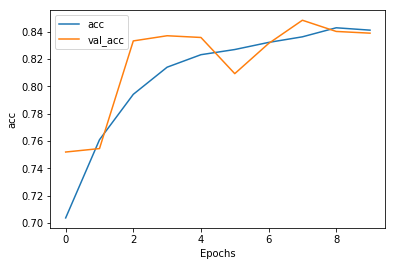

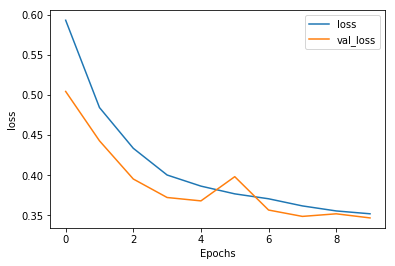

(None, None)

In [36]:
plot_graphs(history2, 'acc'),plot_graphs(history2, 'loss')

In [37]:
# Evaluate the model on the test data using `evaluate`
test_loss, test_acc = model_glove.evaluate(x_eval,y_eval,128)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

3000/3000 [==============================] - 31s 10ms/sample - loss: 0.3352 - acc: 0.8523
Test Loss: 0.33516117723782857
Test Accuracy: 0.8523333072662354


In [38]:
# prediction
def sample_predict(tweet,x_model):
    predictions = ''
    clean_sent = cleaning(tweet,True)
    # noted that parameter [clean_sent], if use tokenizer.texts_to_sequences(clean_sent)
    # the token will give different vector to each word, not a vector for one sentence!
    token_tweet = tokenizer.texts_to_sequences([clean_sent])
    token_tweet_pad = pad_sequences(token_tweet,maxlen=MAXLEN,padding='post')
    result = x_model.predict(token_tweet_pad)
    
    if result < 0.5:
        predictions = 'positive'
    else:
        predictions = 'negative'

    return tweet,result,predictions

Attention:dataset here the `negative` tweets is labeled `1`, `positive` is `0`.

that means while the prediction is closer to 1, it's more predicted as negative.

In [39]:
sample_neg_1 = 'I waited for more than half of an hour for their stupid support!'
sample_neg = 'I hate this phone'
sample_pos = 'I love this!'

In [40]:
pred_pos = sample_predict(sample_pos,model_biGRU)
pred_neg = sample_predict(sample_neg,model_biGRU)
pred_neg_1 = sample_predict(sample_neg_1,model_biGRU)
#print(f'sample tweet:{text}\nprediction:{pred_neg}')
print(f'{pred_pos}\n{pred_neg}\n{pred_neg_1}')

('I love this!', array([[0.07671644]], dtype=float32), 'positive')
('I hate this phone', array([[0.66682684]], dtype=float32), 'negative')
('I waited for more than half of an hour for their stupid support!', array([[0.25103912]], dtype=float32), 'positive')


In [41]:
pred_pos_glove = sample_predict(sample_pos,model_glove)
pred_neg_glove = sample_predict(sample_neg,model_glove)
pred_neg_glove_1 = sample_predict(sample_neg_1,model_glove)
print(f'{pred_pos_glove}\n{pred_neg_glove}\n{pred_neg_glove_1}')

('I love this!', array([[0.01068251]], dtype=float32), 'positive')
('I hate this phone', array([[0.03489757]], dtype=float32), 'positive')
('I waited for more than half of an hour for their stupid support!', array([[0.58549166]], dtype=float32), 'negative')


By using the pre-trained embedding relieves the problem of overfitting, but the model's test accuracy is still unsatisfied :(

maybe we could use other glove embedding or oth

# next update:

- use attention mechanism
- use ELMo as our embeding layer
- use Bert